# APS360 Speech Emotion Recognition


In [2]:
import tensorflow as tf

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Setup

In [1]:
# Install required packages
!pip install pydub
!pip install noisereduce

In [ ]:
# Kaggle setup
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset from Kaggle (direct link: https://www.kaggle.com/dmitrybabko/speech-emotion-recognition-en)
!kaggle datasets download dmitrybabko/speech-emotion-recognition-en

100% 983M/987M [00:12<00:00, 57.9MB/s]
100% 987M/987M [00:12<00:00, 83.3MB/s]


In [ ]:
!mkdir ./data

In [ ]:
%%capture
!unzip speech-emotion-recognition-en.zip -d ./data

## Applying labels & filtering

In [3]:
import os

In [4]:
emotions = {
  'happy': 0, 
  'sad': 1, 
  'angry': 2, 
  'disgust': 3, 
  'fear': 4, 
  'neutral': 5,
  'calm': 6,
  'surprise': 7
}

emotion_count = {
  emotions['happy']: 0, 
  emotions['sad']: 0, 
  emotions['angry']: 0, 
  emotions['disgust']: 0, 
  emotions['fear']: 0, 
  emotions['neutral']: 0, 
  emotions['calm']: 0, 
  emotions['surprise']: 0
}

ravdess_emotions = {
    '01': emotions['neutral'],
    '02': emotions['calm'],
    '03': emotions['happy'],
    '04': emotions['sad'],
    '05': emotions['angry'],
    '06': emotions['fear'],
    '07': emotions['disgust'],
    '08': emotions['surprise']
}

crema_emotions = {
  'SAD': emotions['sad'], 
  'ANG': emotions['angry'], 
  'DIS': emotions['disgust'],
  'FEA': emotions['fear'], 
  'HAP': emotions['happy'], 
  'NEU': emotions['neutral']
}

savee_emotions = {
    'a': emotions['angry'],
    'd': emotions['disgust'],
    'f': emotions['fear'],
    'h': emotions['happy'],
    'n': emotions['neutral']
}

In [5]:
labelled_data = []

data_path = "/content/data"
for root, dirs, files in os.walk(data_path):
  for file in files:
    file_path = os.path.join(root, file)

    dataset = file_path.split('/')[3]
    emotion_label = None
    if dataset == 'Ravdess':
      emotion_label = ravdess_emotions.get(file.split('-')[2], None)
    elif dataset == 'Crema':
      emotion_label = crema_emotions.get(file.split('_')[2], None)
    elif dataset == 'Tess':
      emotion_label = file.split('_')[-1].split('.')[0]
      if emotion_label == 'ps':
        emotion_label = emotions['surprise']
      else:
        emotion_label = emotions.get(emotion_label, None)
    else:
      continue
      # emotion_code = file.split('_')[1][:2]
      # if emotion_code == 'sa':
      #   emotion_label = emotions['sad']
      # elif emotion_code == 'su':
      #   emotion_label = emotions['surprise']
      # else:
      #   emotion_label = savee_emotions.get(emotion_code[0], None)

    if (emotion_label != None):
      emotion_count[emotion_label] += 1
      labelled_data.append([file_path, dataset, emotion_label])

In [6]:
print("Number of audio samples: {}".format(len(labelled_data)))
print("Number of audio samples per emotion: {}".format(emotion_count))

Number of audio samples: 0
Number of audio samples per emotion: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}


In [7]:
import matplotlib.pyplot as plt

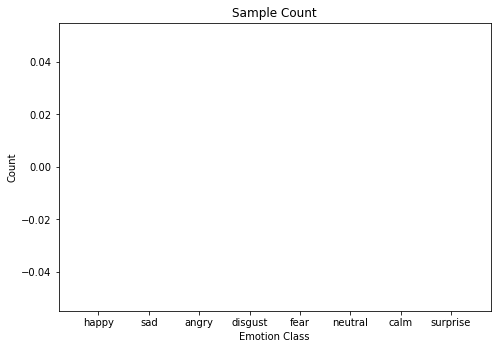

In [8]:
# Plot emotion class counts
classes = ['happy', 'sad', 'angry', 'disgust', 'fear', 'neutral', 'calm', 'surprise']

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
students = emotion_count.values()
ax.bar(classes,students, color=['green', 'green', 'green', 'green', 'green', 'green', 'red', 'red'])
plt.title("Sample Count")
plt.xlabel("Emotion Class")
plt.ylabel("Count")
plt.show()

In [ ]:
# Remove under-represented classes 
filtered_labelled_data = [x for x in labelled_data if (x[2] != emotions['calm'] and x[2] != emotions['surprise'])]

In [ ]:
print("Number of audio samples (after filter): {}".format(len(filtered_labelled_data)))

Number of audio samples (after filter): 10898


## Pre-processing Data

In [9]:
import librosa
import librosa.display
import numpy as np

In [38]:
from pydub import AudioSegment, effects
import noisereduce as nr

In [ ]:
signal_lengths = []
durations = []
for audio in filtered_labelled_data:
  x, sr = librosa.load(path = audio[0], sr = None)
  xt, index = librosa.effects.trim(x, top_db=30)
  signal_lengths.append(len(xt))
  durations.append(librosa.get_duration(xt))

In [ ]:
print("Avg signal length: {}".format(sum(signal_lengths)/len(signal_lengths)))
print("Max duration: {}".format(sum(durations)/len(durations)))

Avg signal length: 45583.40411084603
Max duration: 2.0672745628502347


In [ ]:
avg_signal_length = int(sum(signal_lengths)/len(signal_lengths))

In [129]:
def audio_preprocess(file_name, sample_rate):
  audio = AudioSegment.from_file(file_name)

  # Normalize audio clip
  normalized = effects.normalize(audio)
  normalized_array = np.array(normalized.get_array_of_samples(), dtype = 'float32')

  x_trim, _ = librosa.effects.trim(normalized_array, top_db = 30)
  x_equalized_length = librosa.util.fix_length(x_trim, size = int(45583.40411084603))

  return nr.reduce_noise(y = x_equalized_length, sr = sample_rate)

In [45]:
def extract_features(processed_audio, sample_rate):
  mfccs = librosa.feature.mfcc(y=processed_audio, sr=sample_rate) 
  zcr = librosa.feature.zero_crossing_rate(processed_audio)
  rms = librosa.feature.rms(processed_audio)

  return mfccs, zcr, rms

**Visualization of Feature Extraction**

In [75]:
y, sample_rate = librosa.load('/content/data/Tess/OAF_Fear/OAF_back_fear.wav', sr=None)
processed_audio = audio_preprocess('/content/data/Tess/OAF_Fear/OAF_back_fear.wav', sample_rate)

mfccs, zcr, rms = extract_features(processed_audio, sample_rate)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: ignored

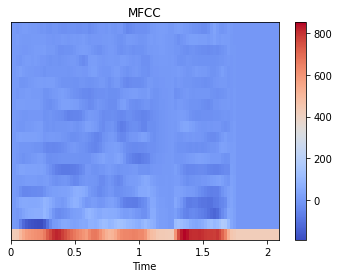

In [ ]:
fig, ax = plt.subplots(nrows=1)
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=[ax])
ax.set(title='MFCC')
librosa.display.specshow(mfccs, x_axis='time')

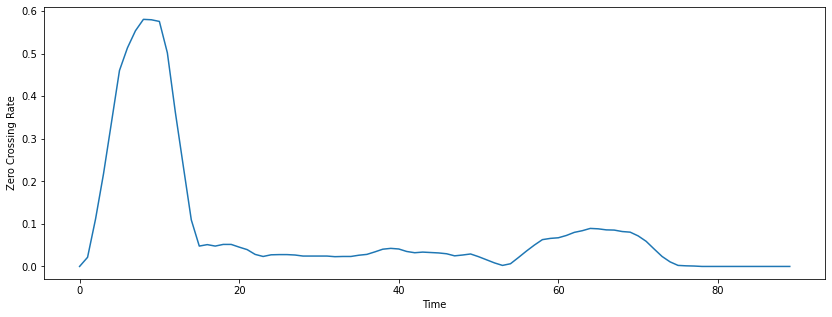

In [ ]:
plt.figure(figsize=(14, 5))
plt.xlabel('Time')
plt.ylabel('Zero Crossing Rate')
plt.plot(zcr[0])

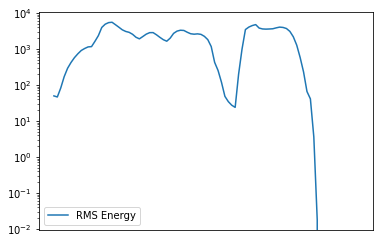

In [ ]:
fig, ax = plt.subplots(nrows=1)
times = librosa.times_like(rms)
ax.semilogy(times, rms[0], label='RMS Energy')
ax.set(xticks=[])
ax.legend()
ax.label_outer()

**Do pre-processing for all data**

In [ ]:
# Obtain features from each wav file
labels = []
features = []

mfccs = []
zcr = []
rms = []
mylists = [mfccs, zcr, rms]
for data in filtered_labelled_data:
  y, sample_rate = librosa.load(data[0], sr=None)

  # Skip corrupted audio samples
  if not np.any(y):
    continue
  
  processed_audio = audio_preprocess(data[0], sample_rate)

  result = extract_features(processed_audio, sample_rate)
  if result is not None:
    labels.append(data[2])
    for x, lst in zip(result, mylists):
      lst.append(x)

In [ ]:
a_mfccs = np.asarray(mfccs).astype('float32')
a_zcr = np.asarray(zcr).astype('float32')
a_rms = np.asarray(rms).astype('float32')

In [ ]:
# The current shape of the np arrays for the features are (samples, feature, timesteps)
# Need in the form of (samples, timesteps, feature) for LSTM
print(a_mfccs.shape)
print(a_zcr.shape)
print(a_rms.shape)

a_mfccs = np.swapaxes(a_mfccs, 1, 2)
a_zcr = np.swapaxes(a_zcr, 1, 2)
a_rms = np.swapaxes(a_rms, 1, 2)

print(a_mfccs.shape)
print(a_zcr.shape)
print(a_rms.shape)

(10897, 20, 90)
(10897, 1, 90)
(10897, 1, 90)
(10897, 90, 20)
(10897, 90, 1)
(10897, 90, 1)


In [ ]:
# Create np arrays for data and labels
X = np.concatenate((a_mfccs, a_zcr, a_rms), axis=2)
Y = np.array(labels)

In [10]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

In [ ]:
# shuffle X and Y same way
# random_state to seed the shuffle
X, Y = shuffle(X, Y, random_state=0)
print(X.shape)
print(Y.shape)

(10897, 90, 22)
(10897,)


**Save preprocessed data**

In [ ]:
x_path = './x_data'
y_path = './y_data'
np.save(x_path, X)
np.save(y_path, Y)

In [ ]:
!zip processed_data_tess_ravdess_crema_2secs.zip x_data.npy y_data.npy

  adding: x_data.npy (deflated 19%)
  adding: y_data.npy (deflated 92%)


**Load preprocessed data**

In [11]:
!unzip processed_data_tess_ravdess_crema_2secs.zip

Archive:  processed_data_tess_ravdess_crema_2secs.zip
  inflating: x_data.npy              
  inflating: y_data.npy              


In [73]:
# load X and Y from npy files
x_path = './x_data.npy'
y_path = './y_data.npy'
X = np.load(x_path)
Y = np.load(y_path)

In [74]:
print(X.shape)
print(Y.shape)

(10897, 90, 22)
(10897,)


In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [16]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=1)

In [17]:
print(Y_val)

[1 5 3 ... 3 4 4]


In [18]:
Y_train_class = tf.keras.utils.to_categorical(Y_train, 6, dtype = 'int8')
Y_val_class = tf.keras.utils.to_categorical(Y_val, 6, dtype = 'int8')

In [19]:
print(Y_val_class)

[[0 1 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 1 0 0]
 ...
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]]


In [20]:
print(len(Y_train_class))
print(len(Y_val_class))

6537
2180


## Training & Utility Functions

In [21]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', True)

Mounted at /content/gdrive


In [22]:
def get_model_path(name, batch_size, learning_rate):
  path = "/content/gdrive/MyDrive/Colab Notebooks/model_{0}_bs{1}_lr{2}_best.hdf5".format(name, batch_size, learning_rate)
  return path

In [23]:
def train(model, batch_size, learning_rate, num_epochs):
  mcp_save = tf.keras.callbacks.ModelCheckpoint(get_model_path(model.name, batch_size, learning_rate), save_best_only=True, 
                                                monitor='val_categorical_accuracy',
                                                mode='max')

  # Reduce learning rate after 100 epoches without improvement.
  rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.1, patience=100)

  # Optimizer
  opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
  # opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  # Compile, train, and evaluate.
  model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])
  return model.fit(X_train, Y_train_class, batch_size=batch_size, epochs=num_epochs, validation_data=(X_val, Y_val_class), callbacks = [mcp_save, rlrop]) 

## Initial Model

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences = True, input_shape=X_train.shape[1:3]),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [23]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 64)            22272     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 55,686
Trainable params: 55,686
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = train(model, 25, 0.001, 100)

Epoch 1/100
262/262 [==============================] - 18s 50ms/step - loss: 1.6087 - accuracy: 0.3379 - categorical_accuracy: 0.3379 - val_loss: 1.5442 - val_accuracy: 0.3711 - val_categorical_accuracy: 0.3711 - lr: 0.0010
Epoch 2/100
262/262 [==============================] - 14s 52ms/step - loss: 1.4522 - accuracy: 0.4214 - categorical_accuracy: 0.4214 - val_loss: 1.3968 - val_accuracy: 0.4321 - val_categorical_accuracy: 0.4321 - lr: 0.0010
Epoch 3/100
262/262 [==============================] - 12s 47ms/step - loss: 1.3768 - accuracy: 0.4536 - categorical_accuracy: 0.4536 - val_loss: 1.3312 - val_accuracy: 0.4867 - val_categorical_accuracy: 0.4867 - lr: 0.0010
Epoch 4/100
262/262 [==============================] - 12s 47ms/step - loss: 1.3190 - accuracy: 0.4814 - categorical_accuracy: 0.4814 - val_loss: 1.2720 - val_accuracy: 0.5069 - val_categorical_accuracy: 0.5069 - lr: 0.0010
Epoch 5/100
262/262 [==============================] - 12s 46ms/step - loss: 1.2588 - accuracy: 0.5114 -

In [24]:
model2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, return_sequences = True, input_shape=X_train.shape[1:3]),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dense(128, activation=tf.nn.softmax),
    tf.keras.layers.Dense(64, activation=tf.nn.softmax),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [25]:
print(model2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 256)           285696    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 852,550
Trainable params: 852,550
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
history2 = train(model2, 20, 0.001, 200)

Epoch 1/200
327/327 [==============================] - 31s 66ms/step - loss: 1.7880 - accuracy: 0.1992 - categorical_accuracy: 0.1992 - val_loss: 1.7840 - val_accuracy: 0.2578 - val_categorical_accuracy: 0.2578 - lr: 0.0010
Epoch 2/200
327/327 [==============================] - 20s 62ms/step - loss: 1.7805 - accuracy: 0.2370 - categorical_accuracy: 0.2370 - val_loss: 1.7727 - val_accuracy: 0.2729 - val_categorical_accuracy: 0.2729 - lr: 0.0010
Epoch 3/200
327/327 [==============================] - 20s 61ms/step - loss: 1.7613 - accuracy: 0.2643 - categorical_accuracy: 0.2643 - val_loss: 1.7477 - val_accuracy: 0.2725 - val_categorical_accuracy: 0.2725 - lr: 0.0010
Epoch 4/200
327/327 [==============================] - 21s 64ms/step - loss: 1.7299 - accuracy: 0.2816 - categorical_accuracy: 0.2816 - val_loss: 1.7290 - val_accuracy: 0.2761 - val_categorical_accuracy: 0.2761 - lr: 0.0010
Epoch 5/200
327/327 [==============================] - 21s 63ms/step - loss: 1.6891 - accuracy: 0.2911 -

**Load best model**

In [26]:
model2.load_weights('/content/gdrive/MyDrive/Colab Notebooks/model_sequential_1_bs20_lr0.001_best.hdf5')

In [30]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model2.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])
Y_test_class = tf.keras.utils.to_categorical(Y_test, 6, dtype = 'int8')


In [31]:
model2.evaluate(X_test, Y_test_class)

69/69 [==============================] - 15s 185ms/step - loss: 1.3711 - accuracy: 0.5950 - categorical_accuracy: 0.5950


[1.371110200881958, 0.5949541330337524, 0.5949541330337524]

## Visualizations

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

In [28]:
def plot_history(history):
  # Plot history: Loss
  plt.plot(history.history['loss'], label='Loss (training data)')
  plt.plot(history.history['val_loss'], label='Loss (validation data)')
  plt.title('Loss for train and validation')
  plt.ylabel('Loss value')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper left")
  plt.show()

  #Plot history: Accuracy
  plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
  plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
  plt.title('Model accuracy')
  plt.ylabel('Acc %')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper left")
  plt.show()

In [29]:
def plot_confusion_matrix(model):
  # Plot confusion matrix
  y_val_class = np.argmax(Y_val_class, axis=1)
  predictions = model.predict(X_val)
  y_pred_class = np.argmax(predictions, axis=1)

  cf_matrix = confusion_matrix(y_val_class, y_pred_class)

  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

  ax.set_title('Emotion Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['happy', 'sad', 'angry', 'disgust', 'fear', 'neutral'])
  ax.yaxis.set_ticklabels(['happy', 'sad', 'angry', 'disgust', 'fear', 'neutral'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

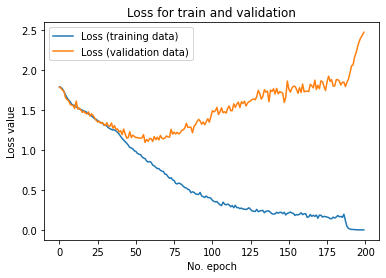

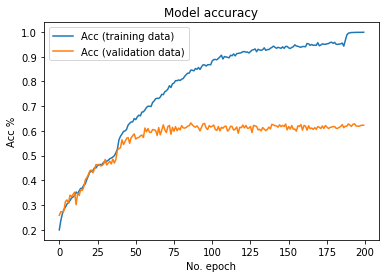

In [30]:
plot_history(history2)

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

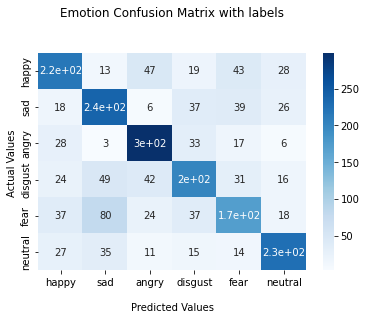

In [32]:
plot_confusion_matrix(model2)

In [35]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=2):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio

In [112]:
x = record(3)

sample_rate = x.frame_rate

import IPython.display as ipd
ipd.Audio(np.array(x.get_array_of_samples(), dtype = 'float32'), rate=x.frame_rate) # load a NumPy array

<IPython.core.display.Javascript object>

In [113]:
normalized = effects.normalize(x)
normalized_array = np.array(normalized.get_array_of_samples(), dtype = 'float32')

x_trim, _ = librosa.effects.trim(normalized_array, top_db = 30)
x_equalized_length = librosa.util.fix_length(x_trim, size = int(45583.40411084603))

mfccs, zcr, rms = extract_features(nr.reduce_noise(y = x_equalized_length, sr = sample_rate), sample_rate)

In [114]:
a_mfccs = np.expand_dims(np.asarray(mfccs).astype('float32'), axis = 0)
a_zcr = np.expand_dims(np.asarray(zcr).astype('float32'), axis = 0)
a_rms = np.expand_dims(np.asarray(rms).astype('float32'), axis = 0)

a_mfccs = np.swapaxes(a_mfccs, 1, 2)
a_zcr = np.swapaxes(a_zcr, 1, 2)
a_rms = np.swapaxes(a_rms, 1, 2)

X = np.concatenate((a_mfccs, a_zcr, a_rms), axis=2)

In [115]:
X.shape

(1, 90, 22)

In [116]:
prediction = model2.predict(X)

In [119]:
print(prediction)

[[2.2703384e-03 9.6325725e-03 4.4613361e-04 2.0755748e-03 1.3250529e-03
  9.8425031e-01]]


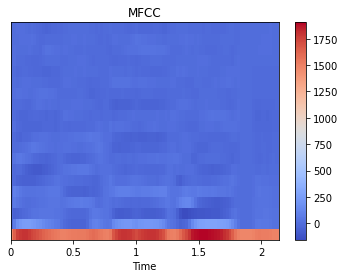

In [47]:
fig, ax = plt.subplots(nrows=1)
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=[ax])
ax.set(title='MFCC')
librosa.display.specshow(mfccs, x_axis='time')

Corpus

In [120]:
! pip install pydub
! pip install noisereduce
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [121]:
! kaggle datasets download -d tli725/jl-corpus

 99% 1.19G/1.20G [00:11<00:00, 137MB/s]
100% 1.20G/1.20G [00:11<00:00, 109MB/s]


In [122]:
!mkdir ./data

In [123]:
%%capture
!unzip jl-corpus.zip -d ./data

In [124]:
emotions = {
  'happy': 0, 
  'sad': 1, 
  'angry': 2
}


processed_data = []

data_path = "/content/data/Raw JL corpus (unchecked and unannotated)/JL(wav+txt)"
for file in os.listdir(data_path):
     filename = os.fsdecode(file)
     file_path = os.path.join(data_path, filename)

     if filename.endswith(".wav"):
         emotion_label = emotions.get(filename.split('_')[1], None)
         if (emotion_label != None):
            processed_data.append([file_path, emotion_label])         
     else:
         continue


In [126]:
print(processed_data[0])

['/content/data/Raw JL corpus (unchecked and unannotated)/JL(wav+txt)/male2_angry_13a_2.wav', 2]


In [131]:
# Obtain features from each wav file
labels = []
features = []

mfccs = []
zcr = []
rms = []
mylists = [mfccs, zcr, rms]
for data in processed_data:
  y, sample_rate = librosa.load(data[0], sr=None)

  # Skip corrupted audio samples
  if not np.any(y):
    continue
  
  processed_audio = audio_preprocess(data[0], sample_rate)

  result = extract_features(processed_audio, sample_rate)
  if result is not None:
    labels.append(data[1])
    for x, lst in zip(result, mylists):
      lst.append(x)

In [133]:
a_mfccs = np.asarray(mfccs).astype('float32')
a_zcr = np.asarray(zcr).astype('float32')
a_rms = np.asarray(rms).astype('float32')

In [134]:
print(a_mfccs.shape)
print(a_zcr.shape)
print(a_rms.shape)

a_mfccs = np.swapaxes(a_mfccs, 1, 2)
a_zcr = np.swapaxes(a_zcr, 1, 2)
a_rms = np.swapaxes(a_rms, 1, 2)

print(a_mfccs.shape)
print(a_zcr.shape)
print(a_rms.shape)

(720, 20, 90)
(720, 1, 90)
(720, 1, 90)
(720, 90, 20)
(720, 90, 1)
(720, 90, 1)


In [135]:
X = np.concatenate((a_mfccs, a_zcr, a_rms), axis=2)
Y = np.array(labels)

In [139]:
Y_test_class = tf.keras.utils.to_categorical(Y, 6, dtype = 'int8')

In [141]:
model2.evaluate(X, Y_test_class)

23/23 [==============================] - 5s 224ms/step - loss: 3.4418 - accuracy: 0.2375 - categorical_accuracy: 0.2375


[3.441781997680664, 0.23749999701976776, 0.23749999701976776]